<h1 align="center"><font size="7" face="arial" color="#73ACCD">Hands-On: Multiscale Entropy (MSE)</font></h1>
<h2 align="center"><font size="6" face="arial" color="#73ACCD">Apply the MSE after a region-based stimulus</font></h2>

<br>
<h2 align="center"><font size="5" face="arial">March 10, 2020</font></h2>
<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Jil Meier &#38; Paul Triebkorn</font></span></h3>
<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial">Charité Universitätsmedizin Berlin, Dept of Neurol, Brain Simulation Section, Berlin, Germany</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:jil-mona&#38;.meier@charite.de">jil-mona.meier@charite.de</a>, <a href="mailto:jan-paul&#38;.triebkorn@charite.de">jan-paul.triebkorn@charite.de</a></font></span></h3>

Multiscale entropy after a region stimulus
=========================

This tutorial describes the process of adding a stimulus defined at the 
region level to a simulation and calculating the multiscale entropy (MSE) of this process. 
Stimuli defined at the region level can also be applied to a surface level simulation.
In that case the stimuli applied to cortical regions are mapped to all 
vertices belonging to that region. 

Here, we will define a basic stimulus at the region level and apply it to a 
region level simulation. We'll use a fairly boring deterministic simulation
so that the effects of the stimuli are very clear. 

In addition, we will load and compare the real-world data of two healthy persons, one 30-year old person and one 68-year-old person. 


## The constraints: 

- Make a demo as simple as possible and thus not including the sub-cortical structures. Many sensory inputs go first through the thalamus and then its projections reach the cortex. 
- Directly stimulating the cortex with an arbitrary stimulus. Intensity units are arbitrary.  

Setup
-----

Here we'll skip quickly over the configuration that was covered in previous tutorials. 

In [1]:
!pip install -U tvb-library

Requirement already up-to-date: tvb-library in /opt/app-root/lib/python3.6/site-packages (2.0.9)
You should consider upgrading via the '/opt/app-root/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%pylab nbagg
from tvb.simulator.lab import *

from pylab import *
import numpy
from tvb.simulator.lab import *
from matplotlib import pyplot
LOG = get_logger('demo')
import matplotlib.gridspec as gridspec
from tvb.datatypes.projections import ProjectionSurfaceEEG
from tvb.datatypes.sensors import SensorsEEG
from tvb.datatypes.region_mapping import RegionMapping
cwd=os.getcwd()
from tvb.analyzers.info import sampen
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## Loading real subject data
We will load the data of a 30-year old person scanned here in Berlin.

In [3]:
conn = connectivity.Connectivity.from_file(os.path.join(cwd,"data","BerlinSubject_30yo.zip"))
conn.configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Let us visualize the loaded connectivity and tract lengths matrices for this 30-year old subject.

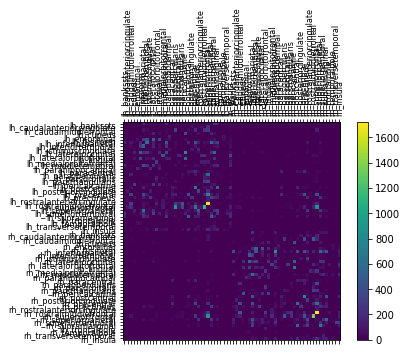

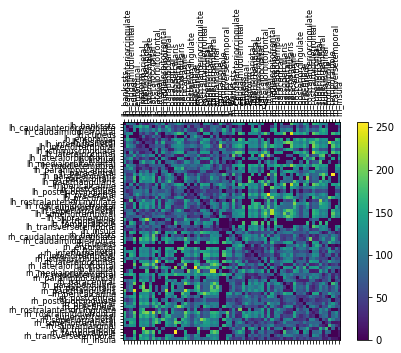

In [4]:
plot_connectivity(connectivity = conn)

Defining the Stimuli
--------------------

### Spatial and temporal pattern of the stimulus:

We'll begin by selecting nodes and defining the weighting
of the stimuli coming into those nodes, to show what the basic process looks like.

In [5]:
weighting = numpy.zeros((68, ))
weighting[[14, 52, 11, 49]] = 0.1

We now need to define the temporal profile. This is done by selecting
an equation and setting its parameters as desired.

An important thing to note is that, the time defined for the stimuli is
relative to a call of the Simulator. That is, if you run a simulation for 
100ms, and then run the same simulator for a further 100ms (note: continuation
of this sort is discussed in another tutorial) then you'll end up with the
same stimuli repeated 

In [6]:
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 1.5e3 # ms
eqn_t.parameters['T'] = 100.0
eqn_t.parameters['tau'] = 50.0

Now we need to combine these spatial and temporal components into a StimuliRegion object,
which can then be used in the construction of our simulator

In [7]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=conn,
    weight=weighting)

We can take a quick look at the basic structure of the stimuli we've just defined using
one of the built in plotting tools.

The plotting tool we'll use provides a simple overview of the stimuli's structure. It 
assumes the stimulus object is already configured, so we start by configuring the object.
This configuration step is actually taken care of automagically within the simulator, so
when you don't want to look at your stimuli before running a simulation this step isn't 
necessary.

NOTE: while the information necessary to configure space is provided by the Connectivity
object, for time it is necessary to explicitly provide a time vector. When a simulation
is run, this time vector is generated internally based on the integration scheme's dt and
the simulation length requested when you call the simulator.

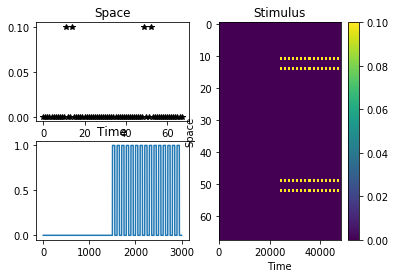

In [8]:
#Configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 3e3, 2**-4))

#And take a look
plot_pattern(stimulus)

What you should see above are three plots: top-left is the spatial component of the stimuli,
indicating the strength with which the stimuli enters each node; bottom-left is the temporal 
profile for the stimuli; and the colour plot on the right represents the combination of these
two components.

## Simulate

Now, we just create & run the simulation,

In [9]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=np.array(0.3), tau=np.array(2)),
    connectivity=conn,
    coupling=coupling.Difference(a=np.array(7e-4)),
    integrator=integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=np.array([5e-5]))),
    monitors=[monitors.TemporalAverage(period=1.0)],
    stimulus=stimulus,
    simulation_length=5e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data),  = sim.run()

One specific thing here is that, because simulations started without ideal initial conditions can 
often have a large transient at the start of the simulation, we need to run the simulator for 
a bit to clear this transient, otherwise the transient would dominate our stimuli and be difficult
to see in the resulting data.

NOTE: If you have a strong stimuli with long-lasting effects on the dynamics, it is possible to 
effectively turn off the stimuli for the purpose of running this initial transient clearing step
and then reinitialise it before running the main simulation.

## Visualize

Text(0.5, 0, 'Time (ms)')

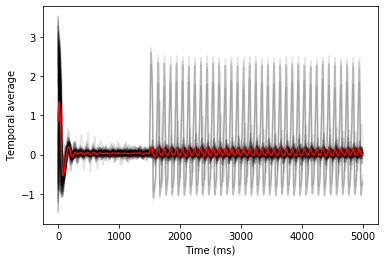

In [10]:
figure()
plot(tavg_time, tavg_data[:, 0, :, 0], 'k', alpha=0.1)
plot(tavg_time, tavg_data[:, 0, :, 0].mean(axis=1), 'r', alpha=1)
ylabel("Temporal average")
xlabel('Time (ms)')

If you look closely at the time-series above you'll notice that oscillations occur in 
nodes not directly stimulated, this, of course, is an effect of the activity propagating
across the brain network defined by the Connectivity.

## Calculate the multiscale entropy to quantify the complexity of this time series

Quantify the complexity per region and visualize the entropy over multiple time scales (MSE). We, then will average the MSE over all regions.

In [11]:
i=0 #let us leave a dimension for adding a second person

#initialize array for the sample entropy of all regions
sampen_allregions=np.empty((68,2,16))
#initialize array for the average sample entropy over all regions
sampen_avg=np.empty((2,16))
#convert simulation results to an array
TAVG = numpy.array(tavg_data)

for y in range(67): #loop over all regions and calculate the sample entropy from the time series
    sampen_allregions[y,i,:] = sampen(TAVG[2048:, 0, y, 0], r=.15, taus=numpy.r_[4:20], qse=False, m=2)
    
for j in range(15): #now for each monitored time point, average the sample entropy value over all regions
         sampen_avg[i,j] = numpy.mean(sampen_allregions[:,i,j])

Visualize sample entropy of this time series

Text(0.5, 0, 'temporal scale')

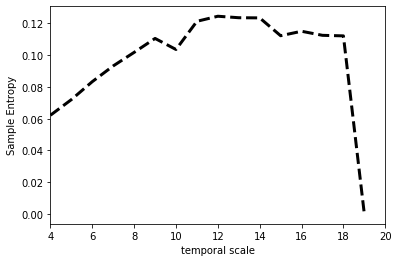

In [12]:
figure()
plot(numpy.r_[4:20], sampen_avg[0,:], 'k--', linewidth=3)

xlim([4, 20])
ylabel("Sample Entropy")
xlabel("temporal scale")

## Adding data of a second person

Now let us also load the connectome of another person, a 68-year-old person scanned here in Berlin.

In [13]:
conn2 = connectivity.Connectivity.from_file(os.path.join(cwd,"data","BerlinSubject_68yo.zip"))

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Let us perform the same simulation as above on the connectome of this second person, with the same stimulus.

In [14]:
conn2.configure()

sim2 = simulator.Simulator(
    model=models.Generic2dOscillator(a=np.array(0.3), tau=np.array(2)),
    connectivity=conn2,
    coupling=coupling.Difference(a=np.array(7e-4)),
    integrator=integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=np.array([5e-5]))),
    monitors=[monitors.TemporalAverage(period=1.0)],
    stimulus=stimulus,
    simulation_length=5e3, # 1 minute simulation
    ).configure()

(tavg_time2, tavg_data2),  = sim2.run()

Let us also visualize the time series for this person and visualize the influence of the stimulus here:

Text(0.5, 0, 'Time (ms)')

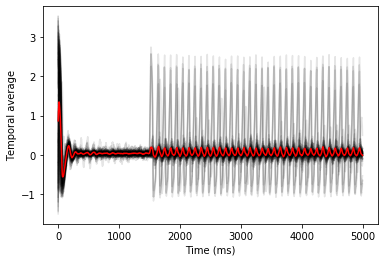

In [15]:
figure()
plot(tavg_time2, tavg_data2[:, 0, :, 0], 'k', alpha=0.1)
plot(tavg_time2, tavg_data2[:, 0, :, 0].mean(axis=1), 'r', alpha=1)
ylabel("Temporal average")
xlabel('Time (ms)')

Comparing this plot with the one from the 30-year-old person, we do not see any obvious differences from the time series plot. Therefore, let us also calculate the MSE for this person averaged over all the regions.

In [16]:
i=1 # this time we put the results in the second entry of the variables below
TAVG2 = numpy.array(tavg_data2)

for y in range(67): #loop over all regions and calculate the sample entropy from the time series
    sampen_allregions[y,i,:] = sampen(TAVG2[2048:, 0, y, 0], r=.15, taus=numpy.r_[4:20], qse=False, m=2)
    
for j in range(15): #now for each monitored time point, average the sample entropy value over all regions
         sampen_avg[i,j] = numpy.mean(sampen_allregions[:,i,j])

Now let us plot the MSE for both persons and compare them:

Text(0.5, 0, 'temporal scale')

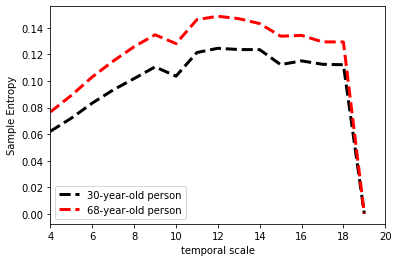

In [17]:
figure()
plot(numpy.r_[4:20], sampen_avg[0,:], 'k--', linewidth=3, label='30-year-old person')

plot(numpy.r_[4:20], sampen_avg[1,:], 'r--', linewidth=3, label='68-year-old person')
legend(loc=3)
xlim([4, 20])
ylabel("Sample Entropy")
xlabel("temporal scale")

What do you see? Did you expect this result? How can we interpret the above MSE plot?

# Additional optional tasks:

Feel free to try out the tasks below to get an even better understanding of the multiscale entropy.

## 1) How does the MSE of our default connectome look like?
## 2) How does the MSE look like if we only consider resting-state activity without the stimulus?